# **IMPORT LIBRARY**

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle
import shutil
import numpy as np
import tensorflow as tf
from PIL import Image

from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# **Connect With Google Drive**

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Set Path to Dataset**

In [3]:
# Paths to the dataset subfolders
base_path = '/content/drive/MyDrive/dataset'

In [4]:
# Path to the Dataset folder
train_dir = os.path.join(base_path, 'train')
valid_dir = os.path.join(base_path, 'valid')
test_dir = os.path.join(base_path, 'test')

# **Configuring and Evaluating Datasets for Model Training**

In [34]:
# Set up ImageDataGenerator for train, valid, and test with augmentation on the train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up ImageDataGenerator for each dataset
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

valid_dataset = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

# Function to display the number of images per class
def display_class_counts(dataset, dataset_name):
    class_counts = {class_name: 0 for class_name in dataset.class_indices.keys()}
    for label in dataset.classes:
        class_name = list(dataset.class_indices.keys())[list(dataset.class_indices.values()).index(label)]
        class_counts[class_name] += 1

    print(f"\nNumber of images per class in the {dataset_name} data:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")

# Display the number of images per class for train, valid, and test
display_class_counts(train_dataset, 'train')
display_class_counts(valid_dataset, 'valid')
display_class_counts(test_dataset, 'test')

Found 1200 images belonging to 6 classes.
Found 240 images belonging to 6 classes.
Found 60 images belonging to 6 classes.

Number of images per class in the train data:
Blepharitis: 200
Conjunctivitis: 200
Entropion: 200
Eyelid_Lump: 200
Nuclear Sclerosis: 200
Pigmented keratitis: 200

Number of images per class in the valid data:
Blepharitis: 40
Conjunctivitis: 40
Entropion: 40
Eyelid_Lump: 40
Nuclear Sclerosis: 40
Pigmented keratitis: 40

Number of images per class in the test data:
Blepharitis: 10
Conjunctivitis: 10
Entropion: 10
Eyelid_Lump: 10
Nuclear Sclerosis: 10
Pigmented keratitis: 10


## Retrieve the first batch of images and labels

In [ ]:
images, labels = next(iter(train_dataset))

print(f"Maximum pixel value of images: {np.max(images)}\n")
print(f"Shape of batch of images: {images.shape}")
print(f"Shape of batch of labels: {labels.shape}")

Maximum pixel value of images: 1.0

Shape of batch of images: (32, 224, 224, 3)
Shape of batch of labels: (32,)


# **MODEL**

In [ ]:
def create_model():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),

        layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.4),

        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.4),

        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.4),

        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(9, activation='softmax')
    ])
    return model

# Create the compiled but untrained model
model = create_model()

In [ ]:
# Print a summary to check total and layer-specific parameters
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,952,489 (18.89 MB)

 Trainable params: 4,952,489 (18.89 MB)

 Non-trainable params: 0 (0.00 B)

## Configuring the Optimizer and Compiling the Model

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Implementing Early Stopping Callback for Training Optimization

In [ ]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        if train_accuracy is not None and val_accuracy is not None:
            if train_accuracy >= 0.99 and val_accuracy >= 0.99:
                self.model.stop_training = True

                print("\nReached 99% train accuracy and 99% validation accuracy, so cancelling training!")

## Setting Up Model Checkpoint Callback to Save Best Weights

In [ ]:
# Define the path for saving model weights
checkpoint_path = "/content/drive/MyDrive/model1_same_checkpoint.weights.h5"

# Callback to save the model after each epoch
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

## Training the Model with Early Stopping and Checkpoint Callbacks

In [ ]:
# Train the model and save the training history
training_history = model.fit(
	train_dataset,
	epochs=150,
	validation_data=valid_dataset,
	callbacks = [EarlyStoppingCallback(), checkpoint_callback]
)

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/38 ━━━━━━━━━━━━━━━━━━━━ 8s 9s/step - accuracy: 0.1975 - loss: 3.0026 
Epoch 1: val_accuracy improved from -inf to 0.18750, saving model to /content/drive/MyDrive/model1_same_checkpoint.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 515s 11s/step - accuracy: 0.1986 - loss: 2.9962 - val_accuracy: 0.1875 - val_loss: 2.9680
Epoch 2/150
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.2706 - loss: 2.6547
Epoch 2: val_accuracy improved from 0.18750 to 0.42500, saving model to /content/drive/MyDrive/model1_same_checkpoint.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 490ms/step - accuracy: 0.2716 - loss: 2.6524 - val_accuracy: 0.4250 - val_loss: 2.8525
Epoch 3/150
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.3526 - loss: 2.4780
Epoch 3: val_accuracy improved from 0.42500 to 0.45417, saving model to /content/drive/MyDrive/model1_same_checkpoint.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 495ms/step - accuracy: 0.3547 - loss: 2.4733 - val_accuracy: 0.4542 - val_loss: 2.6521
Epoch 4/150
37/3

##  Evaluating the Model on the Test Dataset

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9347 - loss: 0.6229
Test accuracy: 0.9333333373069763


# **Visualizing Training and Validation Metrics**

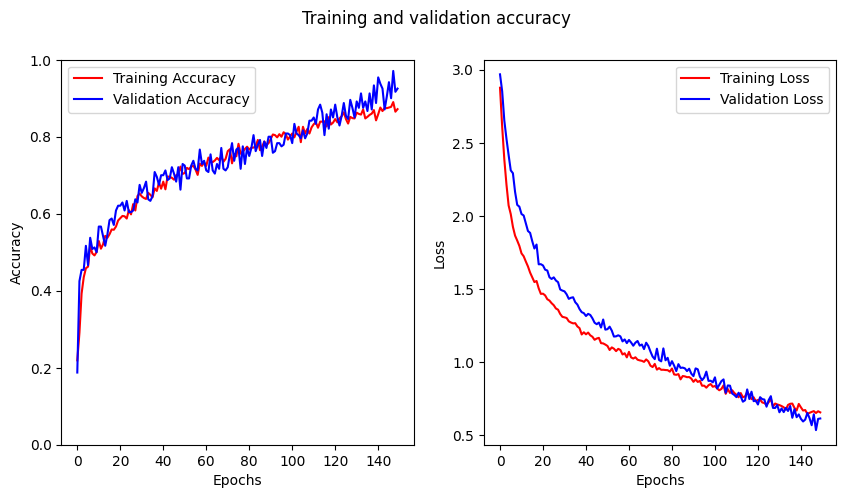

In [ ]:
# Get training and validation accuracies
acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Define the custom ticks for the X axis (e.g., 0, 10, 20, ..., max epoch)
epoch_ticks = range(0, len(acc), 20)  # Adjust 20 to any other interval if needed

# Get the min and max values for loss to dynamically adjust the Y-axis range
loss_min = min(min(loss), min(val_loss))
loss_max = max(max(loss), max(val_loss))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(label)

    if label == "Accuracy":
        ax[i].set_ylim(0, 1)  # Set Y-axis range for accuracy from 0 to 1
    else:
        # Set Y-axis range for loss based on the min and max values
        ax[i].set_ylim(loss_min - 0.1, loss_max + 0.1)  # Add some padding for better visualization

    ax[i].set_xticks(epoch_ticks)  # Set custom X-axis ticks
    ax[i].set_xticklabels([str(e) for e in epoch_ticks])  # Display epoch numbers

plt.show()


# **SAVE MODEL**

In [ ]:
# Save the model to drive
model.save('/content/drive/My Drive/dog_disease_detection_model.h5')

### Convert Model to TensorFlow Lite

In [ ]:
# Load the Keras model
model = load_model('/content/drive/My Drive/dog_disease_detection_model.h5')

# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('dog_disease_detection_model(same).tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted to TensorFlow Lite!")